<a href="https://colab.research.google.com/github/JFMitu/JFMitu/blob/main/Data120_Jannat_ep30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install torch torchvision timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.1 MB/s eta 0:00:00


In [5]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

In [6]:
!pip install scikit-learn numpy

In [7]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [8]:
# Define paths for the dataIset
data_dir = '/content/drive/MyDrive/rice_leaf_diseases120'
batch_size = 32

In [9]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
# Load the entire dataset from Google Drive
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

In [11]:
# Calculate the sizes of train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [12]:
print("Total Size:", train_size+test_size+val_size)
print("Train Size:", train_size)
print("Test Size:", test_size)
print("validation Size:", test_size)

Total Size: 120
Train Size: 84
Test Size: 18
validation Size: 18


In [13]:
# Create data loaders for train, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [14]:
num_classes = len(dataset.classes)
print("Number of classes: ", num_classes)

Number of classes:  3


In [15]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model
inception_model = InceptionV3(weights='imagenet')
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Print model summary
inception_model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)        

In [16]:
from timm.models.inception_v3 import inception_v3
class inception_v3(nn.Module):
    def __init__(self, num_classes):
        super(inception_v3, self).__init__()
        self.inception_v3 = models.inception_v3(pretrained=True)
        in_features = self.inception_v3.fc.in_features
        self.inception_v3.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.inception_v3(x)

In [17]:
import timm
import torch.nn as nn
import torch.optim as optim

# Define the model architecture (timm's Inception V3)
model = timm.create_model('inception_v3', pretrained=True)

num_classes = len(dataset.classes)

model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust the final fully connected layer

# Move the model to a suitable device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

InceptionV3(
  (Conv2d_1a_3x3): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Conv2d_2a_3x3): ConvNormAct(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Conv2d_2b_3x3): ConvNormAct(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): ConvNormAct(
    (conv): Conv2d(64, 80, kernel_size

In [18]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [19]:
# Lists to store training loss and accuracy for each epoch
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [20]:
# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    validation_loss = val_loss / len(val_loader)
    validation_accuracy = correct_val / total_val
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}% - "
          f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy*100:.2f}%")

print("Finished Training")


Epoch [1/30] - Train Loss: 1.0836, Train Accuracy: 42.86% - Validation Loss: 1.0021, Validation Accuracy: 44.44%
Epoch [2/30] - Train Loss: 1.0154, Train Accuracy: 53.57% - Validation Loss: 0.9659, Validation Accuracy: 55.56%
Epoch [3/30] - Train Loss: 0.9325, Train Accuracy: 76.19% - Validation Loss: 0.9003, Validation Accuracy: 72.22%
Epoch [4/30] - Train Loss: 0.8341, Train Accuracy: 90.48% - Validation Loss: 0.8564, Validation Accuracy: 83.33%
Epoch [5/30] - Train Loss: 0.7523, Train Accuracy: 95.24% - Validation Loss: 0.7902, Validation Accuracy: 83.33%
Epoch [6/30] - Train Loss: 0.6446, Train Accuracy: 96.43% - Validation Loss: 0.7303, Validation Accuracy: 94.44%
Epoch [7/30] - Train Loss: 0.5333, Train Accuracy: 100.00% - Validation Loss: 0.6757, Validation Accuracy: 94.44%
Epoch [8/30] - Train Loss: 0.4853, Train Accuracy: 100.00% - Validation Loss: 0.6459, Validation Accuracy: 88.89%
Epoch [9/30] - Train Loss: 0.3833, Train Accuracy: 100.00% - Validation Loss: 0.5954, Validati

In [21]:
# Testing loop
test_accuracies = []

model.eval()
correct_predictions_test = 0
total_samples_test = 0

class_correct = [0] * len(train_dataset.dataset.classes)  # Use train_dataset.dataset.classes
class_total = [0] * len(train_dataset.dataset.classes)    # Use train_dataset.dataset.classes

predicted_labels = []
actual_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_samples_test += labels.size(0)
        correct_predictions_test += (predicted == labels).sum().item()

        # Store predicted and actual labels
        predicted_labels.extend(predicted.tolist())
        actual_labels.extend(labels.tolist())

        # Calculate correct predictions for each class
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

    test_accuracy = correct_predictions_test / total_samples_test
    test_accuracies.append(test_accuracy)
    print(f"Testing Accuracy: {test_accuracy*100:.2f}%")
    print(f"Total Correct Predictions on Test Set: {correct_predictions_test} out of {total_samples_test} samples")

Testing Accuracy: 94.44%
Total Correct Predictions on Test Set: 17 out of 18 samples


In [22]:
!pip install tabulate

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


# Evaluation
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")




Test Accuracy: 94.44%
Precision: 0.95
Recall: 0.94
F1 Score: 0.94


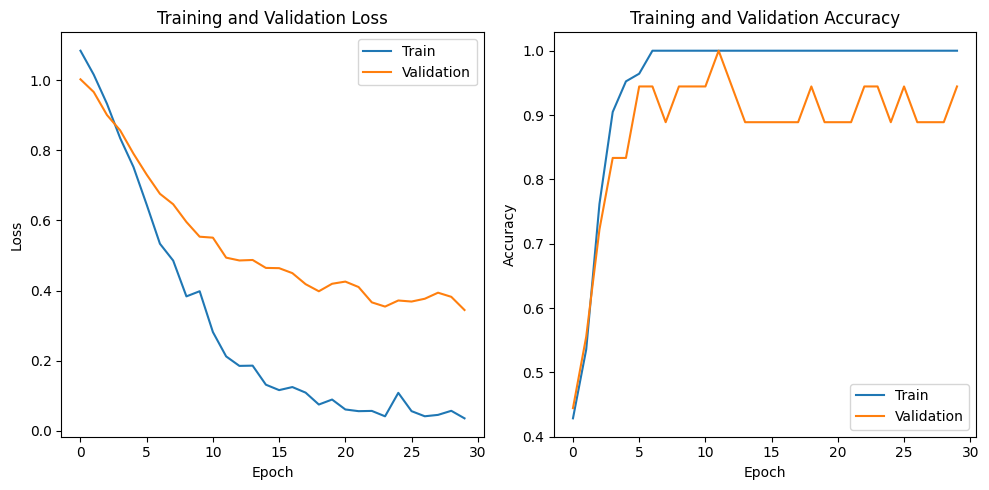

In [24]:
# Plotting the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

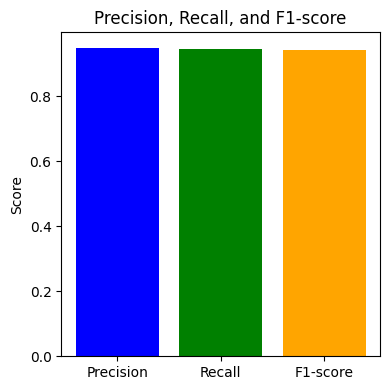

In [26]:
# Plot Precision, Recall, and F1-score
metrics = ['Precision', 'Recall', 'F1-score']
values = [precision, recall, f1]
plt.figure(figsize=(4, 4))
plt.bar(metrics, values, color=['blue', 'green', 'orange'])
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score')
plt.tight_layout()
plt.show()


<Axes: >

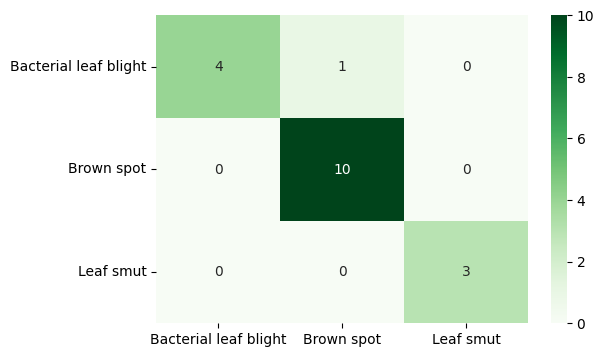

In [37]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens",
            xticklabels=dataset.classes, yticklabels=dataset.classes)

In [38]:
from tabulate import tabulate
# Print predicted and actual labels in a table
table_data = []
for i in range(len(predicted_labels)):
    table_data.append([i + 1, test_dataset.dataset.classes[predicted_labels[i]], test_dataset.dataset.classes[actual_labels[i]]])

table_headers = ["Sample", "Predicted Label", "Actual Label"]
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

+----------+-----------------------+-----------------------+
|   Sample | Predicted Label       | Actual Label          |
+==========+=======================+=======================+
|        1 | Brown spot            | Brown spot            |
+----------+-----------------------+-----------------------+
|        2 | Brown spot            | Brown spot            |
+----------+-----------------------+-----------------------+
|        3 | Bacterial leaf blight | Bacterial leaf blight |
+----------+-----------------------+-----------------------+
|        4 | Bacterial leaf blight | Bacterial leaf blight |
+----------+-----------------------+-----------------------+
|        5 | Leaf smut             | Leaf smut             |
+----------+-----------------------+-----------------------+
|        6 | Brown spot            | Brown spot            |
+----------+-----------------------+-----------------------+
|        7 | Brown spot            | Brown spot            |
+----------+------------

In [39]:
table_data = []
for i, class_name in enumerate(test_dataset.dataset.classes):
    accuracy = class_correct[i] / class_total[i] * 100 if class_total[i] > 0 else 0.0
    table_data.append([class_name, class_correct[i], class_total[i], f"{accuracy:.2f}%"])

table_headers = ["Class", "Correct", "Total", "Accuracy"]
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

+-----------------------+-----------+---------+------------+
| Class                 |   Correct |   Total | Accuracy   |
+=======================+===========+=========+============+
| Bacterial leaf blight |         4 |       5 | 80.00%     |
+-----------------------+-----------+---------+------------+
| Brown spot            |        10 |      10 | 100.00%    |
+-----------------------+-----------+---------+------------+
| Leaf smut             |         3 |       3 | 100.00%    |
+-----------------------+-----------+---------+------------+


In [40]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(actual_labels, predicted_labels, average='weighted')

# Create a table with weighted precision, recall, and F1-score
weighted_metrics = [["Weighted", precision, recall, f1]]

table_headers = ["Class", "Precision", "Recall", "F1-score"]
print(tabulate(weighted_metrics, headers=table_headers, tablefmt="grid"))


# Calculate confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)
# Print confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

+----------+-------------+----------+------------+
| Class    |   Precision |   Recall |   F1-score |
+==========+=============+==========+============+
| Weighted |    0.949495 | 0.944444 |   0.942681 |
+----------+-------------+----------+------------+

Confusion Matrix:
[[ 4  1  0]
 [ 0 10  0]
 [ 0  0  3]]


In [41]:
# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(actual_labels, predicted_labels, average=None)

# Create a table with precision, recall, and F1-score
table_data = []
for i, class_name in enumerate(test_dataset.dataset.classes):
    table_data.append([class_name, precision[i], recall[i], f1[i]])

table_headers = ["Class", "Precision", "Recall", "F1-score"]
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

+-----------------------+-------------+----------+------------+
| Class                 |   Precision |   Recall |   F1-score |
+=======================+=============+==========+============+
| Bacterial leaf blight |    1        |      0.8 |   0.888889 |
+-----------------------+-------------+----------+------------+
| Brown spot            |    0.909091 |      1   |   0.952381 |
+-----------------------+-------------+----------+------------+
| Leaf smut             |    1        |      1   |   1        |
+-----------------------+-------------+----------+------------+


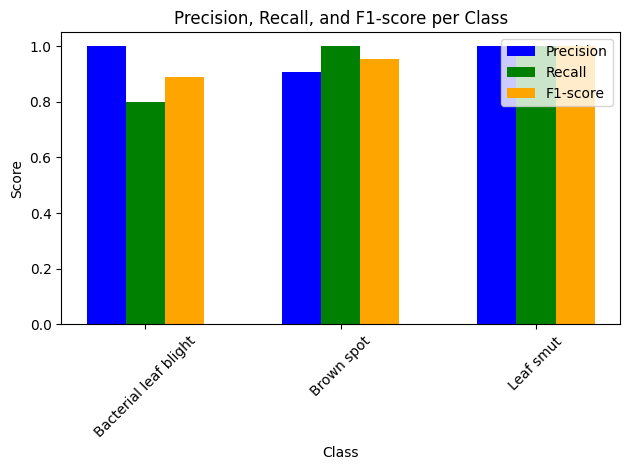

In [42]:

# Plot precision, recall, and F1-score
x = np.arange(len(test_dataset.dataset.classes))
width = 0.2

plt.bar(x - width, precision, width, label='Precision', color='blue')
plt.bar(x, recall, width, label='Recall', color='green')
plt.bar(x + width, f1, width, label='F1-score', color='orange')

plt.xlabel("Class")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-score per Class")
plt.xticks(x, test_dataset.dataset.classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()